#First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

In [1]:
#import all libraries i might need
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import json
from datetime import datetime
from sqlalchemy import create_engine
import seaborn as sns


In [2]:
#Import All data sets
receipts_data = pd.read_json('receipts.json',lines=True)
brands_data = pd.read_json('brands.json',lines=True)
user_data = pd.read_json('users.json',lines=True)

##Looking Into Receipts Data

In [3]:
receipts_data.head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedu...",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedu...",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


In [4]:
print(receipts_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    float64
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptItemList   679 non-null    object 
 12  rewardsReceiptStatus     1119 non-null   object 
 13  totalSpent               684 non-null    float64
 14  userId                  

In [5]:
receipts_data = receipts_data.explode('rewardsReceiptItemList')
receipts_data.reset_index(inplace=True)

In [6]:
receipts_data = receipts_data.fillna({'rewardsReceiptItemList':'{}'})
receipts_data['rewardsReceiptItemList'] = receipts_data['rewardsReceiptItemList'].apply(lambda x:str(x))
receipts_data['rewardsReceiptItemList'] = receipts_data['rewardsReceiptItemList'].apply(literal_eval)


In [7]:
receipts_norm = pd.json_normalize(receipts_data['rewardsReceiptItemList'],errors='ignore',record_prefix='rewardsReceiptItemList')\
.add_prefix('rewardsReceiptItemList.')

In [8]:
receipts_final = pd.merge(receipts_data, receipts_norm, left_index=True, right_index=True, how='outer')

In [9]:
receipts_final
receipts_final.to_csv('receipts_final.csv', index=False)

In [10]:
def date_converter(x):
  try:
    return(datetime.utcfromtimestamp(int(x['$date'])/1000).strftime('%Y-%m-%d %H:%M:%S'))
  except TypeError:
    return(None)


In [11]:
receipts_final['_id'] = receipts_final['_id'].apply(lambda x: x['$oid'])
receipts_final['createDate'] = receipts_final['createDate'].apply(lambda x: date_converter(x))
receipts_final['dateScanned'] = receipts_final['dateScanned'].apply(lambda x: date_converter(x))
receipts_final['finishedDate'] = receipts_final['finishedDate'].apply(lambda x: date_converter(x))
receipts_final['modifyDate'] = receipts_final['modifyDate'].apply(lambda x: date_converter(x))
receipts_final['pointsAwardedDate'] = receipts_final['pointsAwardedDate'].apply(lambda x: date_converter(x))
receipts_final['purchaseDate'] = receipts_final['purchaseDate'].apply(lambda x: date_converter(x))


In [13]:
receipts_final.head()
receipts_final.to_csv('receipts_final.csv', index=False)

#Brand DATA

In [14]:
brands_data.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,0.0,NaN
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,0.0,STARBUCKS
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827


In [15]:
brands_new = pd.json_normalize(brands_data['cpg'])
brands_new = brands_new.add_prefix('cpg.')

In [17]:
brands_new

,cpg.$ref,cpg.$id.$oid
0,Cogs,601ac114be37ce2ead437550
1,Cogs,5332f5fbe4b03c9a25efd0ba
2,Cogs,601ac142be37ce2ead437559
3,Cogs,601ac142be37ce2ead437559
4,Cogs,5332fa12e4b03c9a25efd1e7
...,...,...
1162,Cogs,5f77274dbe37ce6b592e90bf
1163,Cogs,53e10d6368abd3c7065097cc
1164,Cogs,5332fa12e4b03c9a25efd1e7
1165,Cogs,5332f5f6e4b03c9a25efd0b4


In [18]:
brands_final = pd.merge(brands_data, brands_new, left_index=True, right_index=True, how='outer')


In [20]:
brands_final['_id'] = brands_final['_id'].apply(lambda x: x['$oid'])

In [19]:
brands_final.head()

,_id,barcode,category,categoryCode,cpg,name,topBrand,brandCode,cpg.$ref,cpg.$id.$oid
0,{'$oid': '601ac115be37ce2ead437551'},511111019862,Baking,BAKING,"{'$id': {'$oid': '601ac114be37ce2ead437550'}, ...",test brand @1612366101024,0.0,NaN,Cogs,601ac114be37ce2ead437550
1,{'$oid': '601c5460be37ce2ead43755f'},511111519928,Beverages,BEVERAGES,"{'$id': {'$oid': '5332f5fbe4b03c9a25efd0ba'}, ...",Starbucks,0.0,STARBUCKS,Cogs,5332f5fbe4b03c9a25efd0ba
2,{'$oid': '601ac142be37ce2ead43755d'},511111819905,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176,Cogs,601ac142be37ce2ead437559
3,{'$oid': '601ac142be37ce2ead43755a'},511111519874,Baking,BAKING,"{'$id': {'$oid': '601ac142be37ce2ead437559'}, ...",test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051,Cogs,601ac142be37ce2ead437559
4,{'$oid': '601ac142be37ce2ead43755e'},511111319917,Candy & Sweets,CANDY_AND_SWEETS,"{'$id': {'$oid': '5332fa12e4b03c9a25efd1e7'}, ...",test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827,Cogs,5332fa12e4b03c9a25efd1e7


In [21]:
brands_final.to_csv('brands_final.csv', index=False)

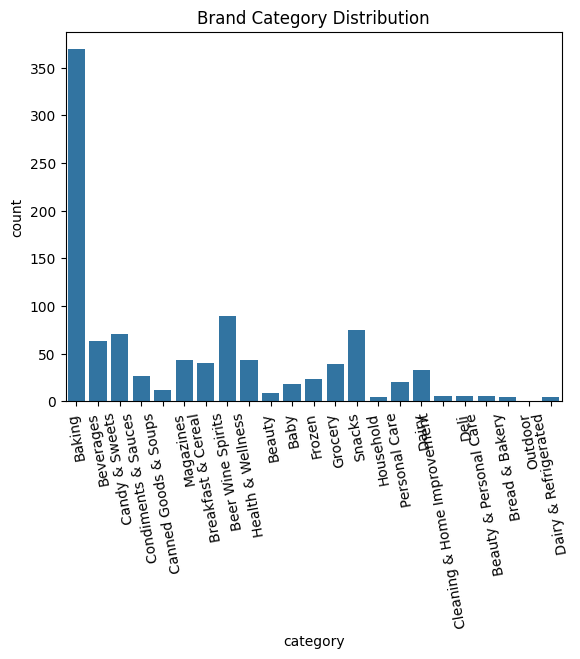

In [22]:
sns.countplot(data=brands_final, x='category')
plt.title('Brand Category Distribution')
plt.xticks(rotation=100)
plt.show()


#USER DATA

In [23]:
user_data.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
1,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
2,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI
3,{'$oid': '5ff1e1eacfcf6c399c274ae6'},True,{'$date': 1609687530554},{'$date': 1609687530597},consumer,Email,WI
4,{'$oid': '5ff1e194b6a9d73a3a9f1052'},True,{'$date': 1609687444800},{'$date': 1609687537858},consumer,Email,WI


In [24]:
user_data['_id'] = user_data['_id'].apply(lambda x: x['$oid'] if isinstance(x, dict) and '$oid' in x else x)
user_data['createdDate'] = user_data['createdDate'].apply(lambda x: pd.to_datetime(x['$date'], unit='ms') if pd.notnull(x) else None)
user_data['lastLogin'] = user_data['lastLogin'].apply(lambda x: pd.to_datetime(x['$date'], unit='ms') if pd.notnull(x) else None)


In [25]:
user_data.head()

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI


In [26]:
user_data.to_csv('user_final.csv', index=False)

#PART 2 Write queries that directly answer predetermined questions from a business stakeholder

In [27]:
engine = create_engine('sqlite://', echo=False)

In [28]:
user_data.drop_duplicates(subset=['_id']).to_sql('users',con=engine)

212

In [29]:
receipts_final.columns = receipts_final.columns.str.replace(".", "_")

In [30]:
receipts_final.drop(columns=['rewardsReceiptItemList'],axis=1).to_sql('receipts',con=engine)

7381

In [31]:
brands_final.drop_duplicates(subset=['brandCode']).drop(columns=['cpg'],axis=1).to_sql('brands',con=engine)

898

In [32]:
print(receipts_final.dtypes)
print(brands_final.dtypes)
print(user_data.dtypes)


index                                                          int64
_id                                                           object
bonusPointsEarned                                            float64
bonusPointsEarnedReason                                       object
createDate                                                    object
dateScanned                                                   object
finishedDate                                                  object
modifyDate                                                    object
pointsAwardedDate                                             object
pointsEarned                                                 float64
purchaseDate                                                  object
purchasedItemCount                                           float64
rewardsReceiptItemList                                        object
rewardsReceiptStatus                                          object
totalSpent                        

In [33]:
# Example for the rewardsReceiptItemList column
receipts_final['rewardsReceiptItemList'] = receipts_final['rewardsReceiptItemList'].apply(lambda x: json.dumps(x) if isinstance(x, dict) else x)


In [34]:
print(brands_final.dtypes)


_id              object
barcode           int64
category         object
categoryCode     object
cpg              object
name             object
topBrand        float64
brandCode        object
cpg.$ref         object
cpg.$id.$oid     object
dtype: object


In [35]:
import sqlite3
import pandas as pd


# Connect to SQLite database
conn = sqlite3.connect('cleaned_data.db')

# Load
user_data = pd.read_csv('user_final.csv')
user_data.to_sql('users', conn, if_exists='replace', index=False)

brand_data = pd.read_csv('brands_final.csv')
brand_data.to_sql('brands', conn, if_exists='replace', index=False)

receipt_data = pd.read_csv('receipts_final.csv')
receipt_data.to_sql('receipts', conn, if_exists='replace', index=False)

# Commit changes
conn.commit()
conn.close()

print("Cleaned data has been imported into the SQLite database.")


Cleaned data has been imported into the SQLite database.


## When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater

In [36]:
import sqlite3
import pandas as pd


# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('cleaned_data.db')

# Load
user_data = pd.read_csv('user_final.csv')
user_data.to_sql('users', conn, if_exists='replace', index=False)

brand_data = pd.read_csv('brands_final.csv')
brand_data.to_sql('brands', conn, if_exists='replace', index=False)

receipt_data = pd.read_csv('receipts_final.csv')
receipt_data.to_sql('receipts', conn, if_exists='replace', index=False)

# Query to calculate average spend for 'Accepted' and 'Rejected' receipt statuses
average_spend_query = """
SELECT
    rewardsReceiptStatus,
    AVG(totalSpent) AS average_spend
FROM
    receipts
WHERE
    rewardsReceiptStatus IN ('FINISHED', 'REJECTED')
GROUP BY
    rewardsReceiptStatus;
"""

# Execute the query and store the results in a DataFrame
average_spend_df = pd.read_sql(average_spend_query, conn)

print("Average Spend by Receipt Status:\n", average_spend_df)


Average Spend by Receipt Status:
   rewardsReceiptStatus  average_spend
0             FINISHED    1244.372934
1             REJECTED      19.544970


In [37]:
import pandas as pd

receipts_data = pd.read_csv('receipts_final.csv')

# Calculate average spend for 'Accepted' and 'Rejected' rewardsReceiptStatus
average_spend = (receipts_data.groupby('rewardsReceiptStatus')['totalSpent']
                 .mean()
                 .reset_index())

# Display the results
print(average_spend)

  rewardsReceiptStatus   totalSpent
0             FINISHED  1244.372934
1              FLAGGED  2635.570247
2              PENDING    28.032449
3             REJECTED    19.544970
4            SUBMITTED          NaN


In [38]:

rewards_list_query = "SELECT rewardsReceiptItemList FROM receipts LIMIT 5;"
rewards_list_samples = pd.read_sql(rewards_list_query, conn)
print("Sample rewardsReceiptItemList Data:\n", rewards_list_samples)


Sample rewardsReceiptItemList Data:
                               rewardsReceiptItemList
0  {'barcode': '4011', 'description': 'ITEM NOT F...
1  {'barcode': '4011', 'description': 'ITEM NOT F...
2  {'barcode': '028400642255', 'description': 'DO...
3  {'needsFetchReview': False, 'partnerItemId': '...
4  {'barcode': '4011', 'description': 'ITEM NOT F...


#When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?**bold text**

In [39]:
import pandas as pd

# Load the cleaned dataset
receipts_data = pd.read_csv('receipts_final.csv')

# Calculate total items purchased for 'Accepted' and 'Rejected' rewardsReceiptStatus
total_items_purchased = (receipts_data.groupby('rewardsReceiptStatus')['purchasedItemCount']
                          .sum()
                          .reset_index())

# Display the results
print(total_items_purchased)

  rewardsReceiptStatus  purchasedItemCount
0             FINISHED           1364998.0
1              FLAGGED            294816.0
2              PENDING                 0.0
3             REJECTED               740.0
4            SUBMITTED                 0.0


#Part 3 Evaluate Data Quality Issues in the Data Provided **bold text**

In [40]:
# data provided brand.json, receipts.json, and users.json
import pandas as pd

#Import All data sets
receipts_data = pd.read_json('receipts.json',lines=True)
brands_data = pd.read_json('brands.json',lines=True)
user_data = pd.read_json('users.json',lines=True)


In [41]:
#Checking if there any missing values

def check_missing_values(df, name):
    missing_data = df.isnull().sum()
    missing_data_percentage = (missing_data / len(df)) * 100
    print(f"\n{name} - Missing Values Report:\n", missing_data_percentage[missing_data_percentage > 0])

check_missing_values(user_data, "Users Data")
check_missing_values(brands_data, "Brands Data")
check_missing_values(receipts_data, "Receipts Data")



Users Data - Missing Values Report:
 lastLogin       12.525253
signUpSource     9.696970
state           11.313131
dtype: float64

Brands Data - Missing Values Report:
 category        13.281919
categoryCode    55.698372
topBrand        52.442159
brandCode       20.051414
dtype: float64

Receipts Data - Missing Values Report:
 bonusPointsEarned          51.385165
bonusPointsEarnedReason    51.385165
finishedDate               49.240393
pointsAwardedDate          52.010724
pointsEarned               45.576408
purchaseDate               40.035746
purchasedItemCount         43.252904
rewardsReceiptItemList     39.320822
totalSpent                 38.873995
dtype: float64


In [42]:
#Checking if there any dulicates values within each dataset

def check_duplicates_with_conversion(df, name):
    df_converted = df.applymap(lambda x: str(x) if isinstance(x, (dict, list)) else x)
    duplicate_count = df_converted.duplicated().sum()
    print(f"{name} - Duplicate Rows (including dict and list columns as strings): {duplicate_count}")

check_duplicates_with_conversion(user_data, "Users Data")
check_duplicates_with_conversion(brands_data, "Brands Data")
check_duplicates_with_conversion(receipts_data, "Receipts Data")



Users Data - Duplicate Rows (including dict and list columns as strings): 283
Brands Data - Duplicate Rows (including dict and list columns as strings): 0
Receipts Data - Duplicate Rows (including dict and list columns as strings): 0


<ipython-input-42-714aa6048435>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_converted = df.applymap(lambda x: str(x) if isinstance(x, (dict, list)) else x)


this is the main issue i encounter because there is some columns that contains lists  and dict

In [43]:
def check_data_types(df, name):
    print(f"\n{name} - Data Types:\n", df.dtypes)

check_data_types(user_data, "Users Data")
check_data_types(brands_data, "Brands Data")
check_data_types(receipts_data, "Receipts Data")



Users Data - Data Types:
 _id             object
active            bool
createdDate     object
lastLogin       object
role            object
signUpSource    object
state           object
dtype: object

Brands Data - Data Types:
 _id              object
barcode           int64
category         object
categoryCode     object
cpg              object
name             object
topBrand        float64
brandCode        object
dtype: object

Receipts Data - Data Types:
 _id                         object
bonusPointsEarned          float64
bonusPointsEarnedReason     object
createDate                  object
dateScanned                 object
finishedDate                object
modifyDate                  object
pointsAwardedDate           object
pointsEarned               float64
purchaseDate                object
purchasedItemCount         float64
rewardsReceiptItemList      object
rewardsReceiptStatus        object
totalSpent                 float64
userId                      object
dtype: ob

In [44]:
# Convert date columns to datetime and check for invalid dates
receipts_data['createDate'] = pd.to_datetime(receipts_data['createDate'], errors='coerce')
print("Invalid createDate entries:", receipts_data['createDate'].isnull().sum())


Invalid createDate entries: 1119


#Summary :

- missing values: lost columns with high percentage of missing data
- duplicates: see the presence of duplicate rows
- data type: see incorrect types
- anomalies: date issues found